In [12]:
import pandas as pd

In [13]:
home_df = pd.read_csv("data/Pl_Home.csv")
away_df = pd.read_csv("data/Pl_Away.csv")
matches_df = pd.read_csv("data/matchweek28_games.csv")

In [14]:
league_avg_home_goals = home_df["GF"].sum() / home_df["MP"].sum()
league_avg_away_goals = away_df["GF"].sum() / away_df["MP"].sum()

In [15]:
home_df["Attack_Strength"] = home_df["GF"] / home_df["MP"] / league_avg_home_goals
away_df["Attack_Strength"] = away_df["GF"] / away_df["MP"] / league_avg_away_goals


In [16]:
home_df["Defense_Strength"] = home_df["GA"] / home_df["MP"] / league_avg_away_goals
away_df["Defense_Strength"] = away_df["GA"] / away_df["MP"] / league_avg_home_goals


### Testing with only 1 Match (Manchester Utd vs Arsenal)

In [17]:
home_stats = home_df[home_df["Squad"] == "Manchester Utd"]
away_stats = away_df[away_df["Squad"] == "Arsenal"]

In [18]:
home_expected_goals = (home_stats["Attack_Strength"].values[0]*
                       away_stats["Defense_Strength"].values[0]*
                       league_avg_home_goals)

In [19]:
home_expected_goals

np.float64(0.8005139101645502)

In [20]:
away_exepected_goals = (away_stats["Attack_Strength"].values[0]*
                        home_stats["Defense_Strength"].values[0]*
                        league_avg_away_goals)

In [21]:
away_exepected_goals

np.float64(1.9640331380076783)

In [22]:
from scipy.stats import poisson
import numpy as np

In [36]:
# creating score probability matrix (for goals 0-6)
score_probabilties = np.zeros((7,7))

In [24]:
for home_goals in range(7):
    for away_goals in range(7):
        home_prob = poisson.pmf(home_goals,home_expected_goals)
        away_prob = poisson.pmf(away_goals,away_exepected_goals)
        score_probabilties[home_goals,away_goals] = home_prob * away_prob

    

In [25]:
score_df = pd.DataFrame(score_probabilties,
                        columns=[f"Arsenal {i} goals" for i in range(7)],
                        index=[f"Manchester Utd {i} goals" for i in range(7)]
                        )

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt


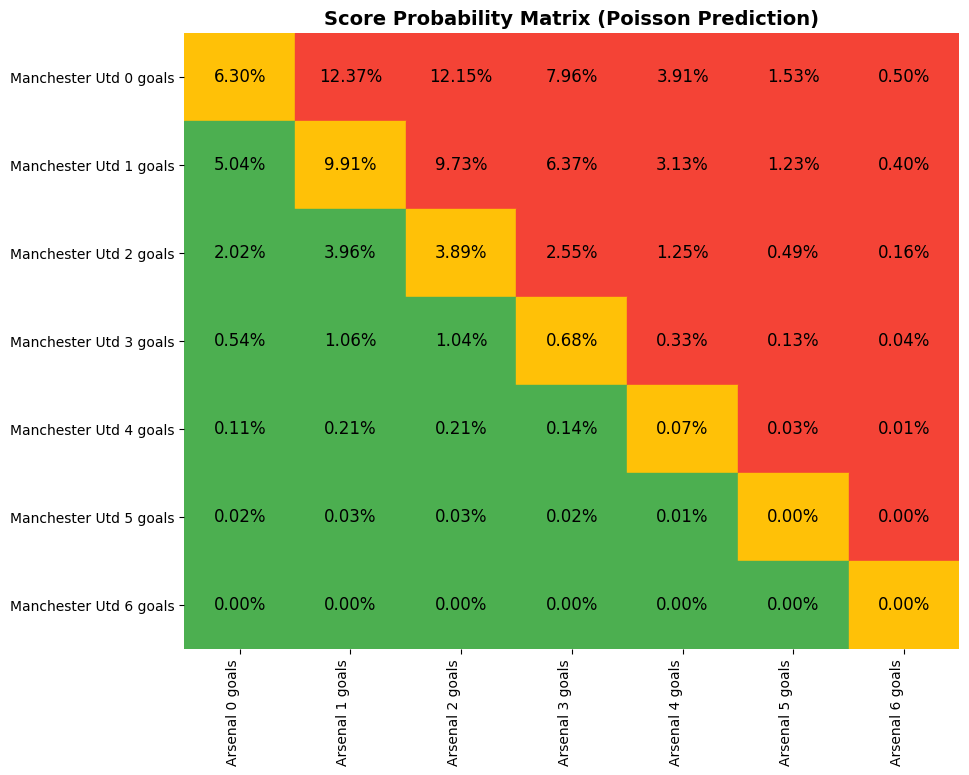

In [27]:
# Define solid colors for the three regions
home_win_color = "#4CAF50"  # Green for Home Wins
draw_color = "#FFC107"  # Yellow for Draws
away_win_color = "#F44336"  # Red for Away Wins

# Create a matrix to store region colors
region_colors = np.full_like(score_probabilties, "", dtype=object)

for i in range(score_df.shape[0]):
    for j in range(score_df.shape[1]):
        if i > j:  
            region_colors[i, j] = home_win_color  # Home Wins (Lower Triangle)
        elif i < j:  
            region_colors[i, j] = away_win_color  # Away Wins (Upper Triangle)
        else:  
            region_colors[i, j] = draw_color  # Draws (Diagonal)

# Create a blank figure
fig, ax = plt.subplots(figsize=(10, 8))

# Manually fill each cell with the appropriate color
for i in range(score_df.shape[0]):
    for j in range(score_df.shape[1]):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=region_colors[i, j]))

# Add text annotations with probability values
for i in range(score_df.shape[0]):
    for j in range(score_df.shape[1]):
        ax.text(j + 0.5, i + 0.5, f"{score_df.iloc[i, j]:.2%}", 
                ha='center', va='center', color="black", fontsize=12)

# Set axis labels
ax.set_xticks(np.arange(score_df.shape[1]) + 0.5)
ax.set_yticks(np.arange(score_df.shape[0]) + 0.5)
ax.set_xticklabels(score_df.columns)
ax.set_yticklabels(score_df.index)
plt.xticks(rotation=90, ha="right")


# Remove grid lines and set aspect ratio
ax.set_xlim(0, score_df.shape[1])
ax.set_ylim(score_df.shape[0], 0)
ax.set_frame_on(False)

# Add title
plt.title("Score Probability Matrix (Poisson Prediction)", fontsize=14, fontweight="bold")

# Show plot
plt.show()

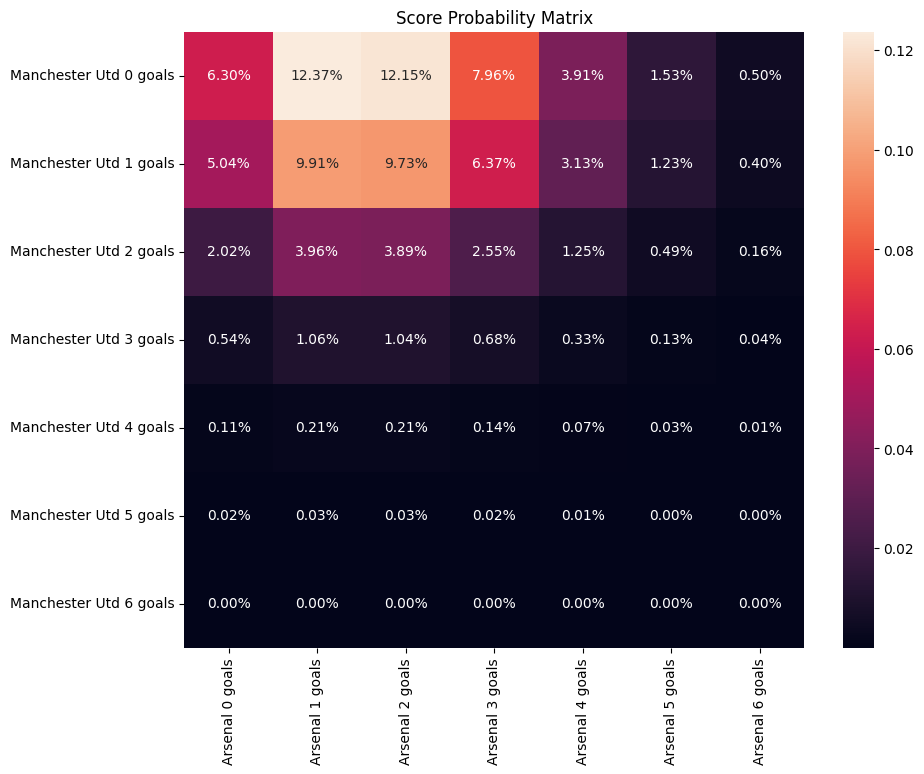

In [28]:
plt.figure(figsize=(10,8))
sns.heatmap(score_df,annot=True,fmt=".2%")
plt.title("Score Probability Matrix")
plt.show()

In [ ]:
# lower triangle 
home_win_prob = np.sum(np.tril(score_probabilties,-1))
# diagonal
draw_prob = np.sum(np.diag(score_probabilties))
# upper triangle
away_win_prob = np.sum(np.triu(score_probabilties,1))

In [30]:
print(f"Chance of Manchester United Winning: {home_win_prob:.2%}")
print(f"Chance of Draw: {draw_prob:.2%}")
print(f"Chance of Arsenal Winning: {away_win_prob:.2%}")



Chance of Manchester United Winning: 14.46%
Chance of Draw: 20.85%
Chance of Arsenal Winning: 64.28%


### Calculating probability of result for all matches

In [31]:
def predict_pl_games(matches_df,home_df,away_df):
    for index, row in matches_df.iterrows():
        home_stats = home_df[home_df["Squad"] == row['Home']]
        away_stats = away_df[away_df["Squad"] == row['Away']]
        home_expected_goals = (home_stats["Attack_Strength"].values[0]*
                       away_stats["Defense_Strength"].values[0]*
                       league_avg_home_goals)
        
        away_exepected_goals = (away_stats["Attack_Strength"].values[0]*
                        home_stats["Defense_Strength"].values[0]*
                        league_avg_away_goals)
        
        score_probabilties = np.zeros((7,7))

        for home_goals in range(7):
            for away_goals in range(7):
                home_prob = poisson.pmf(home_goals,home_expected_goals)
                away_prob = poisson.pmf(away_goals,away_exepected_goals)
                score_probabilties[home_goals,away_goals] = home_prob * away_prob

        
        home_win_prob = np.sum(np.tril(score_probabilties,-1))
        draw_prob = np.sum(np.diag(score_probabilties))
        away_win_prob = np.sum(np.triu(score_probabilties,1))


        if home_win_prob > away_win_prob and home_win_prob > draw_prob:
            prediction = row['Home'] + " win"
            probability = home_win_prob

        elif away_win_prob > home_win_prob and away_win_prob > draw_prob:
            prediction = row['Away'] + " win"
            probability = away_win_prob

        else:
            prediction = "Draw"
            probability = draw_prob

        
        matches_df.at[index, 'Prediction'] = prediction
        matches_df.at[index, '% Chance'] = f"{probability:.2%}"



        
        
    

In [32]:
predict_pl_games(matches_df,home_df,away_df)

### Final predictions

In [33]:
matches_df

,Home,Away,Prediction,% Chance
0,Nott'ham Forest,Manchester City,Nott'ham Forest win,52.75%
1,Liverpool,Southampton,Liverpool win,84.92%
2,Crystal Palace,Ipswich Town,Crystal Palace win,43.30%
3,Brighton,Fulham,Fulham win,37.84%
4,Brentford,Aston Villa,Brentford win,64.90%
5,Wolves,Everton,Wolves win,37.50%
6,Chelsea,Leicester City,Chelsea win,78.31%
7,Tottenham,Bournemouth,Bournemouth win,43.63%
8,Manchester Utd,Arsenal,Arsenal win,64.28%
9,West Ham,Newcastle Utd,Newcastle Utd win,58.82%
